# Visual Weight Estimation - Survey Results - Exploration

## Imports

### Library Imports

In [1]:
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from plotnine import *
import plotly.figure_factory as ff

### Data Imports

#### Paths

In [4]:
SURVEY_BASE_DIR = '<PATH_TO_REPO_ROOT_DIR>'
SURVEY_DATASET_CSV_PATH = f"{SURVEY_BASE_DIR}/survey_dataset.csv"
SURVEY_RESULTS_CSV_PATH = f"{SURVEY_BASE_DIR}/survey_results.csv"

PEOPLE_PREDICTIONS_EXPORT_PATH = f"{SURVEY_BASE_DIR}/people-predictions.pkl"

#### Survey Dataset

In [5]:
survey_dataset = pd.read_csv(SURVEY_DATASET_CSV_PATH)

# Parse column types
survey_dataset = survey_dataset.astype({
    "picture_id": "str",
    "weight": "float",
})

survey_dataset.head()

,picture_id,weight
0,24,502.000000
1,30,354.144531
2,62,609.000000
3,91,109.107422
4,89,115.031250


#### Survey Results

In [6]:
# Read survey results from CSV
survey_results = pd.read_csv(SURVEY_RESULTS_CSV_PATH)

# Parse column types
survey_results = survey_results.astype({
    "submission_id": "str",
    "picture_id": "str",
    "weight_estimation": "int32",
    "user_type": "str",
    "food_recognised": "bool",
    "container_recognised": "bool",
    "duration": "int32",
    "with_prior_training": "bool",
})

# Parse datetime column
survey_results["submission_datetime"] = pd.to_datetime(survey_results["submission_datetime"])

survey_results.head()

,Unnamed: 0.1,submission_id,picture_id,weight_estimation,user_type,food_recognised,container_recognised,duration,submission_datetime,with_prior_training
0,0,ce72a6c5-0577-447e-8815-8c34518b8f3e,64,250,OTHER,False,False,4788,2022-04-25 15:13:34.629,False
1,1,693efe08-3f4b-437f-b8ee-baba2fb8037a,52,100,OTHER,False,False,2736,2022-04-25 16:38:02.234,False
2,2,693efe08-3f4b-437f-b8ee-baba2fb8037a,98,80,OTHER,False,False,1037,2022-04-25 16:38:02.234,False
3,3,693efe08-3f4b-437f-b8ee-baba2fb8037a,88,300,OTHER,False,False,1550,2022-04-25 16:38:02.234,False
4,4,693efe08-3f4b-437f-b8ee-baba2fb8037a,27,900,OTHER,False,False,1791,2022-04-25 16:38:02.234,False


### Pre-processing

#### Set LinkedIn category to Other to simplify analysis

In [7]:
survey_results.loc[survey_results['user_type'] == 'LINKEDIN', 'user_type'] = 'OTHER'

#### Remove unused `with_prior_training` column

In [8]:
survey_results.drop(columns=['with_prior_training'], inplace=True)

#### Filter negative and extreme positive outliers

In [9]:
survey_results = survey_results[survey_results['weight_estimation'] > 0]
survey_results = survey_results[survey_results['weight_estimation'] <= 10000]

#### De-duplication

In [10]:
# Remove duplicate submission for the same image by the same person.
survey_results = survey_results\
    .sort_values(['submission_datetime'], ascending=True)\
    .drop_duplicates(subset=['submission_id', 'picture_id'])

# Remove submissions with less than 15 weight estimations.
survey_results = survey_results.groupby('submission_id')\
    .filter(lambda x: len(x) >= 15)\
    .reset_index(drop=True)

# Take the first 15 submissions for each person so no one is over-represented if someone submitted the survey more than once.
survey_results = survey_results.groupby('submission_id')\
    .head(15)\
    .reset_index(drop=True)

#### Transform duration from ms to seconds

In [11]:
survey_results['duration'] = survey_results['duration'].apply(lambda x: x / 1000)

#### Rename groups

In [12]:
survey_results.loc[survey_results['user_type'] == 'OTHER', 'user_type'] = 'Everyone else'
survey_results.loc[survey_results['user_type'] == 'FOOD COMPANY', 'user_type'] = 'Food Company Employees'
survey_results.loc[survey_results['user_type'] == 'FOOD COMPANY - ANNOTATOR', 'user_type'] = 'Food Company Annotators'

In [13]:
survey_results

,Unnamed: 0.1,submission_id,picture_id,weight_estimation,user_type,food_recognised,container_recognised,duration,submission_datetime
0,1476,8890cee7-2d42-487c-83c9-19541bba76a5,60,3500,Food Company Employees,True,True,1.599,2022-04-25 07:39:11.949
1,1475,8890cee7-2d42-487c-83c9-19541bba76a5,43,300,Food Company Employees,True,True,2.223,2022-04-25 07:39:11.949
2,1478,8890cee7-2d42-487c-83c9-19541bba76a5,52,400,Food Company Employees,True,True,4.124,2022-04-25 07:39:11.949
3,1402,8890cee7-2d42-487c-83c9-19541bba76a5,5,4000,Food Company Employees,False,True,2.669,2022-04-25 07:39:11.949
4,1403,8890cee7-2d42-487c-83c9-19541bba76a5,13,700,Food Company Employees,False,True,2.566,2022-04-25 07:39:11.949
...,...,...,...,...,...,...,...,...,...
1690,1663,a32b409e-85ad-4b4d-96a9-f46d69ff57c8,42,1000,Everyone else,False,True,1.339,2022-05-18 12:47:23.147
1691,1662,a32b409e-85ad-4b4d-96a9-f46d69ff57c8,88,2000,Everyone else,False,True,0.677,2022-05-18 12:47:23.147
1692,1661,a32b409e-85ad-4b4d-96a9-f46d69ff57c8,41,400,Everyone else,False,True,3.750,2022-05-18 12:47:23.147
1693,1613,a32b409e-85ad-4b4d-96a9-f46d69ff57c8,67,1000,Everyone else,False,False,2.340,2022-05-18 12:47:23.147


### Export human predictions for evaluation

In [14]:
human_predictions = survey_results \
    .groupby(by='picture_id') \
    .mean()[['weight_estimation']] \
    .rename(columns={'weight_estimation': 'human'})

human_predictions.to_pickle(PEOPLE_PREDICTIONS_EXPORT_PATH)
human_predictions

,human
picture_id,
0,249.900000
1,336.333333
10,134.333333
100,100.444444
101,330.066667
...,...
95,235.000000
96,3230.789474
97,260.000000


## Exploratory Data Analysis (EDA)

In [15]:
print(f"Total food picture estimations: {len(survey_results)}")
print(f"Total unique survey submissions: {len(survey_results['submission_id'].unique())}")
print(f"Total unique Food Company survey submissions: {len(survey_results[survey_results['user_type'] == 'Food Company Employees']['submission_id'].unique())}")
print(f"Total unique Food Company ANNOTATOR survey submissions: {len(survey_results[survey_results['user_type'] == 'Food Company Annotators']['submission_id'].unique())}")
print(f"Total unique OTHER survey submissions: {len(survey_results[survey_results['user_type'] == 'Everyone else']['submission_id'].unique())}")
print(f"Total unique UNKNOWN survey submissions: {len(survey_results[survey_results['user_type'] == 'UNKNOWN']['submission_id'].unique())}")

Total food picture estimations: 1695
Total unique survey submissions: 113
Total unique Food Company survey submissions: 12
Total unique Food Company ANNOTATOR survey submissions: 3
Total unique OTHER survey submissions: 98
Total unique UNKNOWN survey submissions: 0


In [16]:
print(f'First submission: {survey_results["submission_datetime"].min()}')
print(f'Last submission: {survey_results["submission_datetime"].max()}')

First submission: 2022-04-25 07:39:11.949000
Last submission: 2022-05-18 12:47:23.147000


Mean duration: 2.41 seconds
Min duration: 0.47 seconds
Max duration: 71.58 seconds


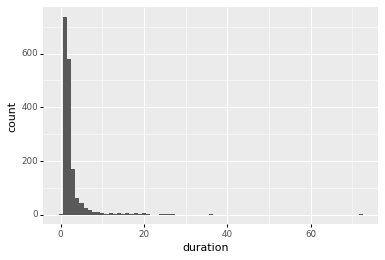

<ggplot: (366779374)>

In [17]:
print(f'Mean duration: {survey_results["duration"].mean():.2f} seconds')
print(f'Min duration: {survey_results["duration"].min():.2f} seconds')
print(f'Max duration: {survey_results["duration"].max():.2f} seconds')

ggplot(survey_results, aes(x = "duration")) \
    + geom_histogram(binwidth = 1) \
    + theme(figure_size=(16, 8))

Mean weight estimation: 571.39 grams
Min weight estimation: 1.00 grams
Max weight estimation: 8000.00 grams


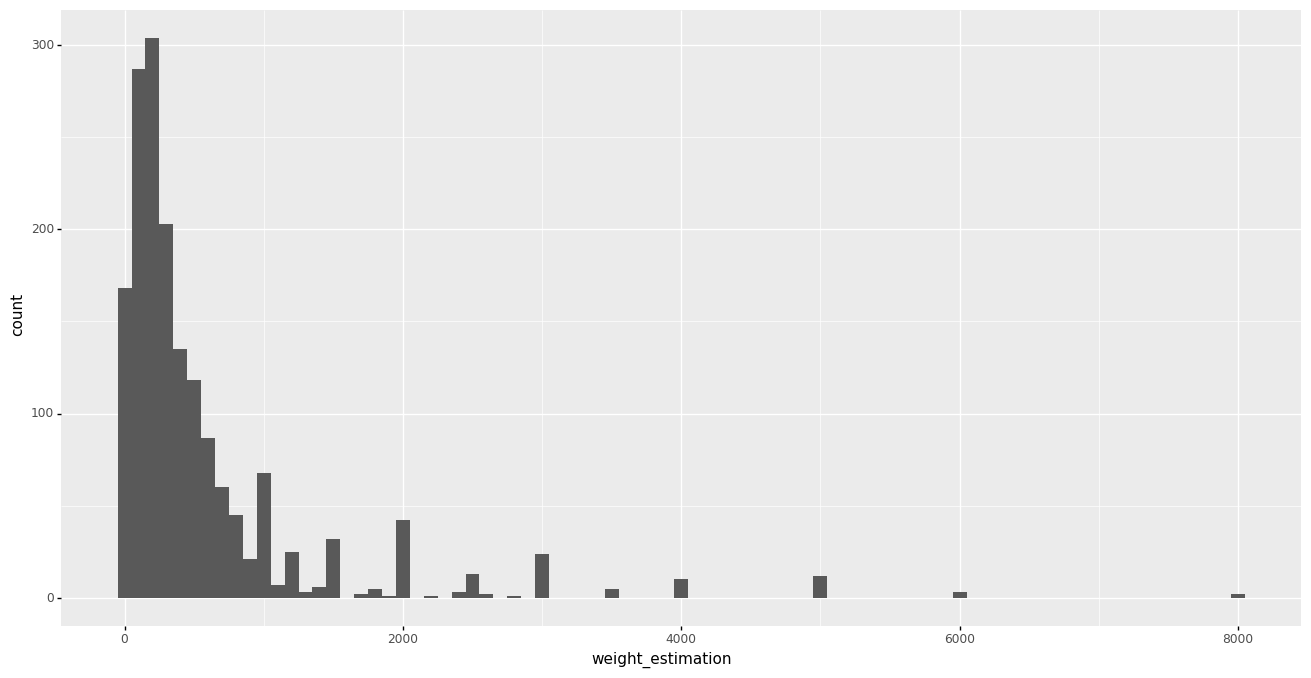

<ggplot: (366869483)>

In [18]:
print(f'Mean weight estimation: {survey_results["weight_estimation"].mean():.2f} grams')
print(f'Min weight estimation: {survey_results["weight_estimation"].min():.2f} grams')
print(f'Max weight estimation: {survey_results["weight_estimation"].max():.2f} grams')

ggplot(survey_results, aes(x = "weight_estimation")) \
    + geom_histogram(binwidth = 100) \
    + theme(figure_size=(16, 8))

In [19]:
food_recongnised_ratio = survey_results['food_recognised'].values.sum() / len(survey_results)
print(f'Food recognised {food_recongnised_ratio * 100:.2f} % of the time')

container_recognised_ratio = survey_results['container_recognised'].values.sum() / len(survey_results)
print(f'Container recognised {container_recognised_ratio * 100:.2f} % of the time')

Food recognised 62.95 % of the time
Container recognised 87.73 % of the time


## Evaluation

In [20]:
survey_results["picture_id"] = survey_results["picture_id"].apply(lambda picture_id: picture_id.split(".")[0])
survey_results.head()

,Unnamed: 0.1,submission_id,picture_id,weight_estimation,user_type,food_recognised,container_recognised,duration,submission_datetime
0,1476,8890cee7-2d42-487c-83c9-19541bba76a5,60,3500,Food Company Employees,True,True,1.599,2022-04-25 07:39:11.949
1,1475,8890cee7-2d42-487c-83c9-19541bba76a5,43,300,Food Company Employees,True,True,2.223,2022-04-25 07:39:11.949
2,1478,8890cee7-2d42-487c-83c9-19541bba76a5,52,400,Food Company Employees,True,True,4.124,2022-04-25 07:39:11.949
3,1402,8890cee7-2d42-487c-83c9-19541bba76a5,5,4000,Food Company Employees,False,True,2.669,2022-04-25 07:39:11.949
4,1403,8890cee7-2d42-487c-83c9-19541bba76a5,13,700,Food Company Employees,False,True,2.566,2022-04-25 07:39:11.949


In [21]:
ground_truth_df = survey_dataset[["picture_id", "weight"]]\
    .rename(columns = {"weight": "ground_truth_weight"})

In [22]:
df = survey_results\
    .merge(ground_truth_df, on="picture_id")
df.head()

,Unnamed: 0.1,submission_id,picture_id,weight_estimation,user_type,food_recognised,container_recognised,duration,submission_datetime,ground_truth_weight
0,1476,8890cee7-2d42-487c-83c9-19541bba76a5,60,3500,Food Company Employees,True,True,1.599,2022-04-25 07:39:11.949,1756.085938
1,228,c6527386-f8e6-4b40-bace-3a16b5f9b67b,60,2800,Everyone else,False,True,2.027,2022-04-25 16:09:55.499,1756.085938
2,1130,71b316e7-0651-4f42-a55e-fe6da8c10782,60,3000,Everyone else,True,True,1.294,2022-04-29 08:06:22.239,1756.085938
3,271,3cfdd7e0-6d64-492e-9d7b-c0ad8897dd51,60,2000,Everyone else,False,True,2.596,2022-04-29 08:11:31.562,1756.085938
4,371,6cf4bda7-d5ac-4607-a77a-b8f9059fcf40,60,800,Everyone else,False,True,0.907,2022-04-29 08:56:30.858,1756.085938


In [23]:
df["error"] = df["ground_truth_weight"] - df["weight_estimation"]
df["absolute_error"] = df["error"].apply(abs)
df['absolute_percentage_error'] = df['absolute_error'] / df['ground_truth_weight']
df.head()

,Unnamed: 0.1,submission_id,picture_id,weight_estimation,user_type,food_recognised,container_recognised,duration,submission_datetime,ground_truth_weight,error,absolute_error,absolute_percentage_error
0,1476,8890cee7-2d42-487c-83c9-19541bba76a5,60,3500,Food Company Employees,True,True,1.599,2022-04-25 07:39:11.949,1756.085938,-1743.914062,1743.914062,0.993069
1,228,c6527386-f8e6-4b40-bace-3a16b5f9b67b,60,2800,Everyone else,False,True,2.027,2022-04-25 16:09:55.499,1756.085938,-1043.914062,1043.914062,0.594455
2,1130,71b316e7-0651-4f42-a55e-fe6da8c10782,60,3000,Everyone else,True,True,1.294,2022-04-29 08:06:22.239,1756.085938,-1243.914062,1243.914062,0.708345
3,271,3cfdd7e0-6d64-492e-9d7b-c0ad8897dd51,60,2000,Everyone else,False,True,2.596,2022-04-29 08:11:31.562,1756.085938,-243.914062,243.914062,0.138896
4,371,6cf4bda7-d5ac-4607-a77a-b8f9059fcf40,60,800,Everyone else,False,True,0.907,2022-04-29 08:56:30.858,1756.085938,956.085938,956.085938,0.544441


In [24]:
def calculate_metrics(df):
    return (
        df["error"].mean(),
        df["absolute_error"].mean(),
        df["absolute_percentage_error"].mean() * 100,
        (df["absolute_error"].sum() / df["ground_truth_weight"].sum()) * 100,
    )

def R_squared(y, y_pred):
    # residual = np.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    residual = (y - y_pred).apply(lambda x: x * x).sum()
    # total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    total = (y - y.mean()).apply(lambda x: x * x).sum()
    # r2 = tf.subtract(1.0, tf.div(residual, total))
    r2 = 1.0 - (residual / total)
    return r2

In [25]:
calculate_metrics(df)

(196.1371900350295, 545.3111437592183, 251.69956206861164, 71.04796146420232)

In [26]:
print(f'Mean Error in grams: {df["error"].mean():.2f}')
print(f'Min Error in grams: {df["error"].min():.2f}')
print(f'Max Error in grams: {df["error"].max():.2f}')
print()
print(f'Mean Absolute Error (MAE) in grams: {df["absolute_error"].mean():.2f}')
print(f'Min Absolute Error in grams: {df["absolute_error"].min():.2f}')
print(f'Max Absolute Error in grams: {df["absolute_error"].max():.2f}')
print()
print(f'Mean Absolute Percentage Error (MAPE) in grams: {df["absolute_percentage_error"].mean() * 100:.2f}')
print(f'Min Absolute Percentage Error in grams: {df["absolute_percentage_error"].min() * 100:.2f}')
print(f'Max Absolute Percentage Error in grams: {df["absolute_percentage_error"].max() * 100:.2f}')
print()
wmape = (df["absolute_error"].sum() / df["ground_truth_weight"].sum()) * 100
print(f'Weighted Mean Absolute Percentage Error (WMAPE) in grams: {wmape:.2f}%')
r2 = R_squared(df['ground_truth_weight'], df['weight_estimation'])
print(f'R2: {r2 * 100:2f}%')

Mean Error in grams: 196.14
Min Error in grams: -4794.66
Max Error in grams: 5737.14

Mean Absolute Error (MAE) in grams: 545.31
Min Absolute Error in grams: 0.39
Max Absolute Error in grams: 5737.14

Mean Absolute Percentage Error (MAPE) in grams: 251.70
Min Absolute Percentage Error in grams: 0.04
Max Absolute Percentage Error in grams: 21928.61

Weighted Mean Absolute Percentage Error (WMAPE) in grams: 71.05%
R2: 24.565190%


Error:


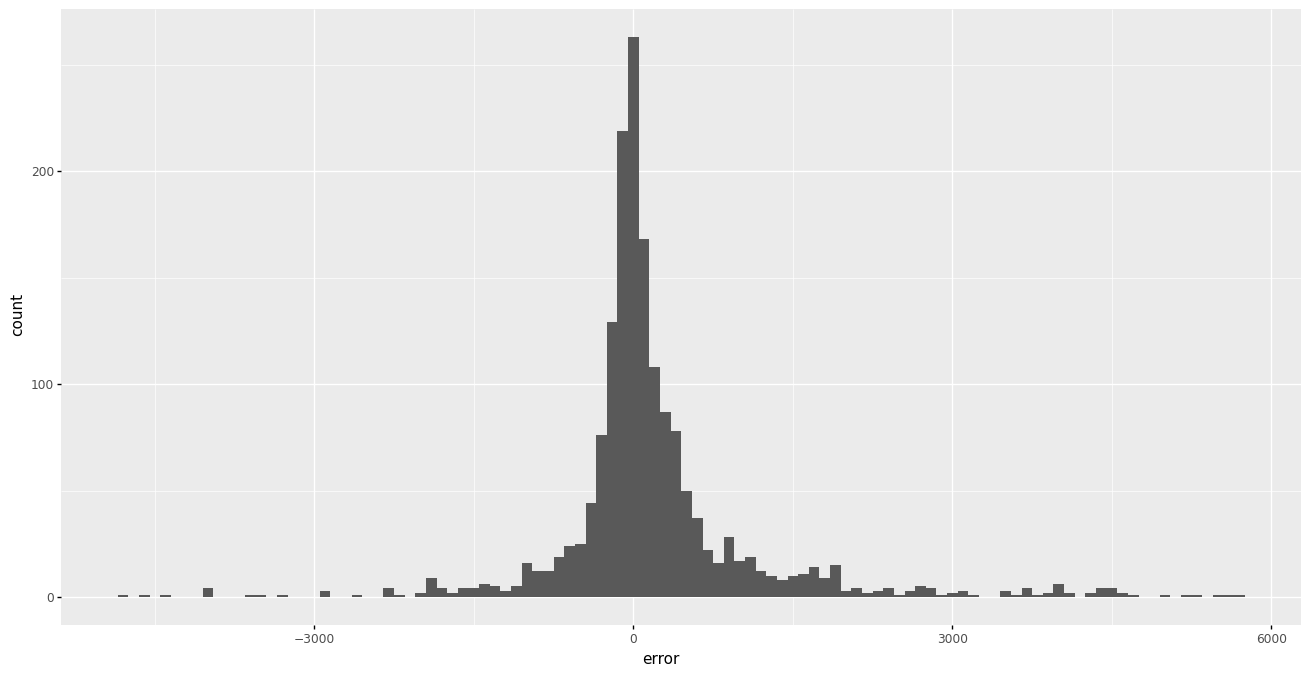

<ggplot: (366852175)>

In [27]:
print('Error:')
ggplot(df, aes(x = "error"))\
    + geom_histogram(binwidth = 100) \
    + theme(figure_size=(16, 8))

Absolute Error:


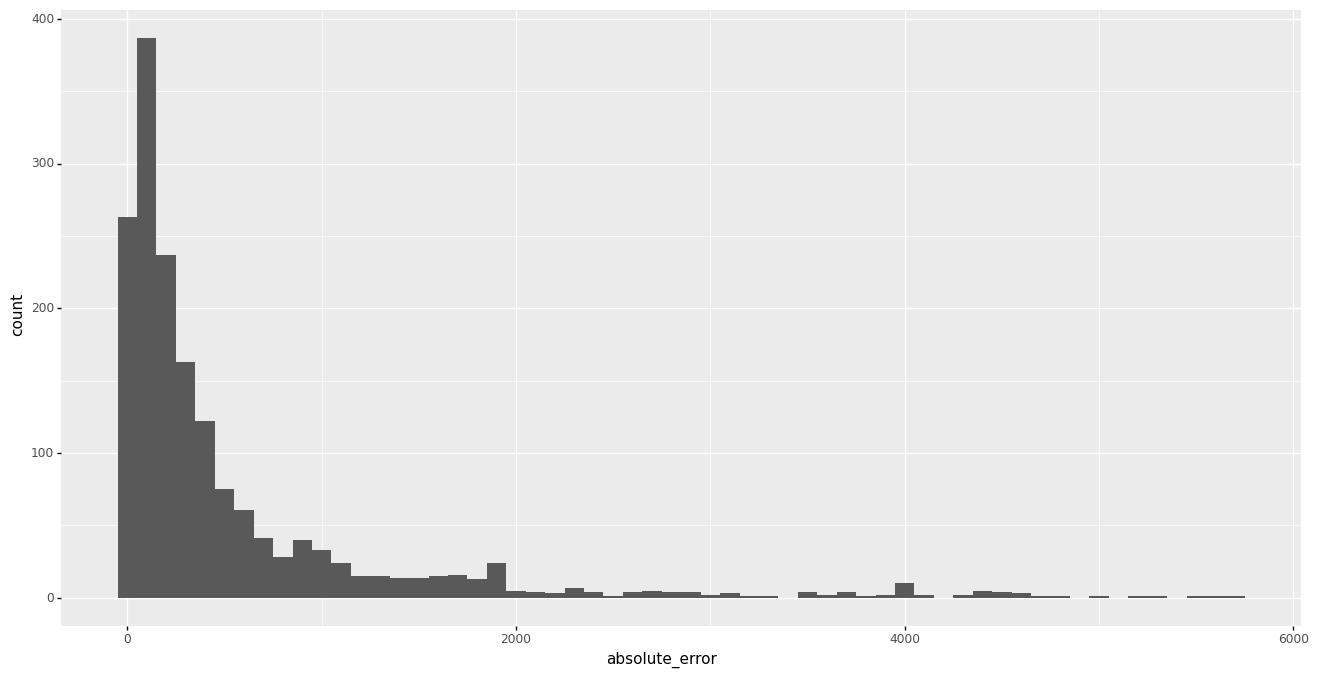

<ggplot: (366986780)>

In [28]:
print('Absolute Error:')
ggplot(df, aes(x = df["absolute_error"])) \
    + geom_histogram(binwidth = 100) \
    + theme(figure_size=(16, 8))

In [29]:
overestimation_ratio = len(df[df["error"] <= 0]) / len(df)

print(f'People overestimate {overestimation_ratio * 100:.2f} % of the time')
print(f'People underestimate {(1 - overestimation_ratio) * 100:.2f} % of the time')

People overestimate 46.08 % of the time
People underestimate 53.92 % of the time


In [30]:
grouped_df = df.groupby(["submission_id", "user_type"]) \
    .mean() \
    .reset_index() \
    .set_index("submission_id")

In [31]:
print(f'Mean Error in grams: {grouped_df["error"].mean():.2f}')
print(f'Min Error in grams: {grouped_df["error"].min():.2f}')
print(f'Max Error in grams: {grouped_df["error"].max():.2f}')

print()
print(f'Mean Absolute Error (MAE) in grams: {grouped_df["absolute_error"].mean():.2f}')
print(f'Min Absolute Error in grams: {grouped_df["absolute_error"].min():.2f}')
print(f'Max Absolute Error in grams: {grouped_df["absolute_error"].max():.2f}')

print()
print(f'Mean Absolute Percentage Error (MAPE) in grams: {grouped_df["absolute_percentage_error"].mean() * 100:.2f}')
print(f'Min Absolute Percentage Error in grams: {grouped_df["absolute_percentage_error"].min() * 100:.2f}')
print(f'Max Absolute Percentage Error in grams: {grouped_df["absolute_percentage_error"].max() * 100:.2f}')

print()
wmape = (grouped_df["absolute_error"].mean() / grouped_df["ground_truth_weight"].mean()) * 100
print(f'Weighted Mean Absolute Percentage Error (WMAPE) in grams: {wmape:.2f}%')

Mean Error in grams: 196.14
Min Error in grams: -1425.25
Max Error in grams: 1125.10

Mean Absolute Error (MAE) in grams: 545.31
Min Absolute Error in grams: 162.71
Max Absolute Error in grams: 1461.81

Mean Absolute Percentage Error (MAPE) in grams: 251.70
Min Absolute Percentage Error in grams: 36.56
Max Absolute Percentage Error in grams: 2636.29

Weighted Mean Absolute Percentage Error (WMAPE) in grams: 71.05%


In [32]:
print('Error:')

fig = ff.create_distplot(
    [df['error']],
    ['Error'],
    histnorm=None,
    show_rug=False,
)

fig.write_html("errors.html")

fig.show()
# fig.write_image("images/fig1.png")


Error:


In [33]:
fig = ff.create_distplot(
    [
        df[df["user_type"] == "Food Company Annotators"]['absolute_error'],
        df[df["user_type"] == "Food Company Employees"]['absolute_error'],
        df[df["user_type"] == "Everyone else"]['absolute_error'],
    ],
    [
        'Food Company Annotators',
        'Food Company Employees',
        'Everyone else',
    ],
)

fig['layout']['legend']['x'] = 0.85
fig['layout']['legend']['y'] = 0.9

fig.show()

fig.write_html("groups-errors.html")

In [34]:
print('Top 5 Submissions:')
grouped_df.sort_values(by="absolute_error").head()

Top 5 Submissions:


,user_type,Unnamed: 0.1,weight_estimation,food_recognised,container_recognised,duration,ground_truth_weight,error,absolute_error,absolute_percentage_error
submission_id,,,,,,,,,,
eef31707-c456-4cda-89ab-48a8e84e6d52,Everyone else,788.266667,347.666667,0.466667,1.000000,1.736467,392.791667,45.125000,162.707031,1.588501
84d6cc22-c543-4845-8eac-3b9e89d4ee14,Everyone else,1638.200000,170.000000,0.200000,0.800000,2.827533,281.929557,111.929557,191.644141,0.970913
ede6b2ef-5ae6-45cb-bb81-1dae1ba9f0e1,Everyone else,740.200000,364.000000,0.600000,1.000000,1.377933,351.806510,-12.193490,196.008333,1.167338
3cfdd7e0-6d64-492e-9d7b-c0ad8897dd51,Everyone else,229.800000,844.666667,0.200000,0.333333,1.752267,777.418750,-67.247917,205.431510,0.907754
8db2e7eb-bcc3-4b33-8b90-6b8dbef2805d,Everyone else,677.666667,318.000000,0.400000,0.933333,1.387533,424.476562,106.476562,219.561979,0.709527


In [35]:
print('Bottom 5 Submissions:')
grouped_df.sort_values(by="absolute_error", ascending = False).head()

Bottom 5 Submissions:


,user_type,Unnamed: 0.1,weight_estimation,food_recognised,container_recognised,duration,ground_truth_weight,error,absolute_error,absolute_percentage_error
submission_id,,,,,,,,,,
a32b409e-85ad-4b4d-96a9-f46d69ff57c8,Everyone else,1690.733333,2400.000000,0.400000,0.866667,2.113733,974.745182,-1425.254818,1461.811849,13.034595
7c15bc24-3b04-4dbb-b19d-09237f06406e,Everyone else,572.200000,2136.666667,0.400000,0.600000,2.539933,965.331250,-1171.335417,1309.304688,8.100210
2b46d386-7ad8-4db7-9b7b-51c06534b5c0,Everyone else,1090.000000,1645.000000,1.000000,1.000000,1.707933,671.857292,-973.142708,1228.190885,2.323900
09e60213-6a1b-464d-a009-9c114438fc18,Everyone else,949.800000,216.666667,0.733333,1.000000,2.829733,1341.767057,1125.100391,1154.589453,0.583334
83349118-3b95-49aa-b745-d89e39c654bd,Everyone else,275.533333,1136.666667,0.200000,0.400000,2.017733,1503.388281,366.721615,1124.662240,2.425554


In [36]:
print(f'Best submission Absolute Error: {grouped_df["absolute_error"].min():.2f}')
print(f'Mean submission Absolute Error: {grouped_df["absolute_error"].mean():.2f}')
print(f'Worst submission Absolute Error: {grouped_df["absolute_error"].max():.2f}')

Best submission Absolute Error: 162.71
Mean submission Absolute Error: 545.31
Worst submission Absolute Error: 1461.81


Overall Submission Absolute Error:


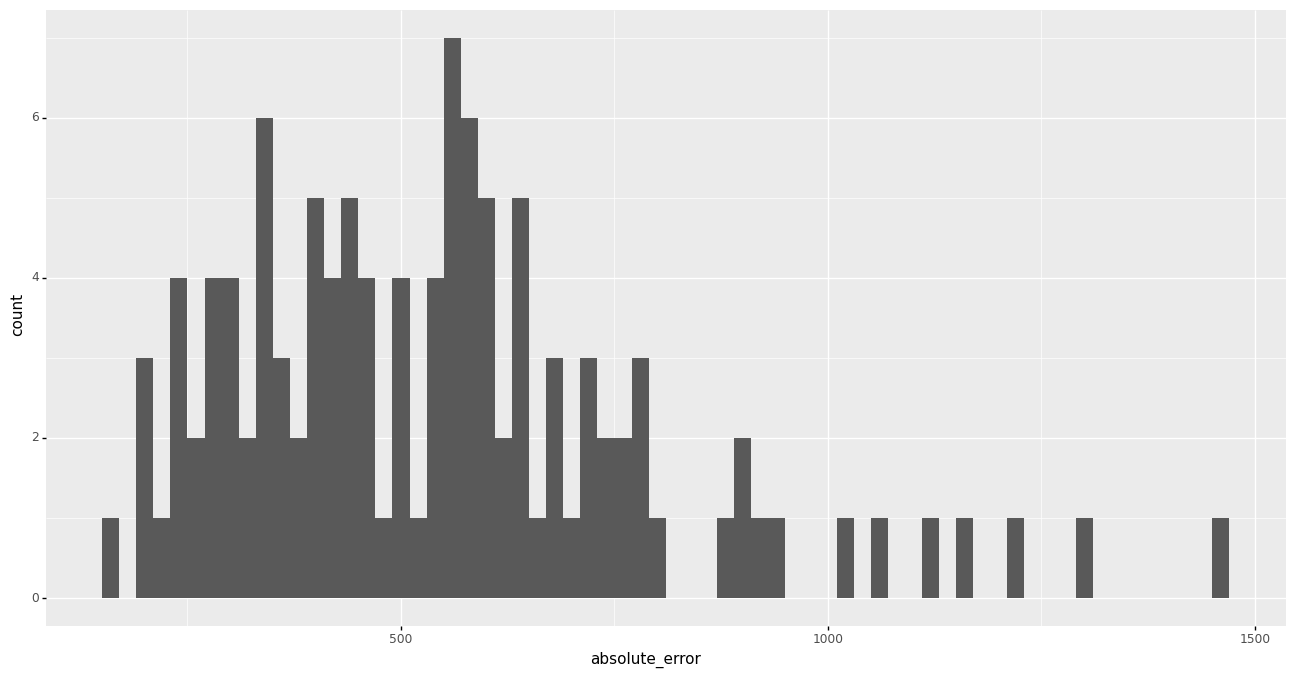

<ggplot: (367602941)>

In [37]:
print('Overall Submission Absolute Error:')
ggplot(grouped_df, aes(x = "absolute_error")) \
    + geom_histogram(binwidth = 20) \
    + theme(figure_size=(16, 8))

In [38]:
food_company_submissions = grouped_df[grouped_df["user_type"] == "Food Company Employees"]
food_company_annotator_submissions = grouped_df[grouped_df["user_type"] == "Food Company Annotators"]
other_submissions = grouped_df[grouped_df["user_type"] == "Everyone else"]
unknown_submissions = grouped_df[grouped_df["user_type"] == "UNKNOWN"]

print(f'Best Food Company error: {food_company_submissions["absolute_error"].min():.2f}')
print(f'Mean Food Company error: {food_company_submissions["absolute_error"].mean():.2f}')
print(f'Worst Food Company error: {food_company_submissions["absolute_error"].max():.2f}')

print()
print(f'Best Food Company - ANNOTATOR error: {food_company_annotator_submissions["absolute_error"].min():.2f}')
print(f'Mean Food Company - ANNOTATOR error: {food_company_annotator_submissions["absolute_error"].mean():.2f}')
print(f'Worst Food Company - ANNOTATOR error: {food_company_annotator_submissions["absolute_error"].max():.2f}')

print()
print(f'Best OTHER error: {other_submissions["absolute_error"].min():.2f}')
print(f'Mean OTHER error: {other_submissions["absolute_error"].mean():.2f}')
print(f'Worst OTHER error: {other_submissions["absolute_error"].max():.2f}')

print()
print(f'Best UNKNOWN error: {unknown_submissions["absolute_error"].min():.2f}')
print(f'Mean UNKNOWN error: {unknown_submissions["absolute_error"].mean():.2f}')
print(f'Worst UNKNOWN error: {unknown_submissions["absolute_error"].max():.2f}')

Best Food Company error: 243.92
Mean Food Company error: 448.93
Worst Food Company error: 779.13

Best Food Company - ANNOTATOR error: 290.67
Mean Food Company - ANNOTATOR error: 392.36
Worst Food Company - ANNOTATOR error: 490.59

Best OTHER error: 162.71
Mean OTHER error: 561.80
Worst OTHER error: 1461.81

Best UNKNOWN error: nan
Mean UNKNOWN error: nan
Worst UNKNOWN error: nan


In [39]:
print(f'ME OVERALl: {grouped_df["error"].mean():.2f}')
print(f'MAE OVERALl: {grouped_df["absolute_error"].mean():.2f}')
print(f'MAPE OVERALl: {grouped_df["absolute_percentage_error"].mean() * 100:.2f}')
print(f'WMAPE OVERALl: {(grouped_df["absolute_error"].mean() / grouped_df["ground_truth_weight"].mean()) * 100:.2f}')

print()
print(f'ME Food Company: {food_company_submissions["error"].mean():.2f}')
print(f'MAE Food Company: {food_company_submissions["absolute_error"].mean():.2f}')
print(f'MAPE Food Company: {food_company_submissions["absolute_percentage_error"].mean() * 100:.2f}')
print(f'WMAPE Food Company: {(food_company_submissions["absolute_error"].mean() / food_company_submissions["ground_truth_weight"].mean()) * 100:.2f}')

print()
print(f'ME Food Company - ANNOTATOR: {food_company_annotator_submissions["error"].mean():.2f}')
print(f'MAE Food Company - ANNOTATOR: {food_company_annotator_submissions["absolute_error"].mean():.2f}')
print(f'MAPE Food Company - ANNOTATOR: {food_company_annotator_submissions["absolute_percentage_error"].mean() * 100:.2f}')
print(f'WMAPE Food Company - ANNOTATOR: {(food_company_annotator_submissions["absolute_error"].mean() / food_company_annotator_submissions["ground_truth_weight"].mean()) * 100:.2f}')

print()
print(f'ME OTHER: {other_submissions["error"].mean():.2f}')
print(f'MAE OTHER: {other_submissions["absolute_error"].mean():.2f}')
print(f'MAPE OTHER: {other_submissions["absolute_percentage_error"].mean() * 100:.2f}')
print(f'WMAPE OTHER: {(other_submissions["absolute_error"].mean() / other_submissions["ground_truth_weight"].mean()) * 100:.2f}')

ME OVERALl: 196.14
MAE OVERALl: 545.31
MAPE OVERALl: 251.70
WMAPE OVERALl: 71.05

ME Food Company: 239.09
MAE Food Company: 448.93
MAPE Food Company: 133.98
WMAPE Food Company: 64.17

ME Food Company - ANNOTATOR: 50.43
MAE Food Company - ANNOTATOR: 392.36
MAPE Food Company - ANNOTATOR: 265.14
WMAPE Food Company - ANNOTATOR: 52.93

ME OTHER: 195.34
MAE OTHER: 561.80
MAPE OTHER: 265.70
WMAPE OTHER: 72.34


<ggplot: (366953954)>

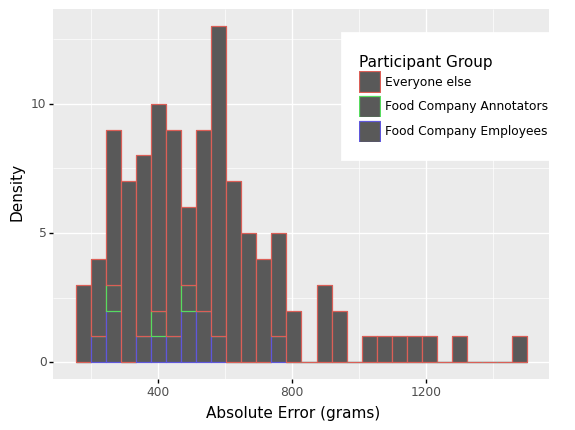

In [40]:
fig, plot = (ggplot(grouped_df, aes(x='absolute_error', colour='user_type', group='user_type')) \
    + geom_histogram(bins=30) \
    + labs(x='Absolute Error (grams)', y='Density', color='Participant Group')\
    + theme(
        legend_position=(0.75, 0.70),
        legend_key=element_rect(fill='white'),
        legend_background=element_rect(color='white', size=2, fill='white'),
    )).draw(show=False, return_ggplot=True)

fig.savefig('survey-participant-group-densities.png', bbox_inches = 'tight')
plot


In [41]:
cat1 = df[df['user_type'] == 'Everyone else']
cat2 = df[(df['user_type'] == 'Food Company Employees') | (df['user_type'] == 'Food Company Annotators')]

print(f'Food Company: {calculate_metrics(cat2)}')
print(f'Everyone else: {calculate_metrics(cat1)}')

ttest_ind(cat1['absolute_error'], cat2['absolute_error'])

Food Company: (201.3582986111111, 437.6126215277778, 160.2096387100516, 61.81799012471415)
Everyone else: (195.33804076318026, 561.7956114477041, 265.7031217663505, 72.33566120305184)


Ttest_indResult(statistic=2.0486884710819617, pvalue=0.040646481047692744)

In [42]:
food_recognised = df[df['food_recognised'] == True]
food_not_recognised = df[df['food_recognised'] == False]

print(f'MAE food_recognised: {food_recognised["absolute_error"].mean()}')
print(f'MAE food_not_recognised: {food_not_recognised["absolute_error"].mean()}')

print(f'food_recognised: {calculate_metrics(food_recognised)}')
print(f'food_not_recognised: {calculate_metrics(food_not_recognised)}')

ttest_ind(food_recognised['absolute_error'], food_not_recognised['absolute_error'])

MAE food_recognised: 578.1638556554592
MAE food_not_recognised: 489.49292147691085
food_recognised: (240.68068877401592, 578.1638556554592, 245.82915486097215, 67.18162388468929)
food_not_recognised: (120.4557996616242, 489.49292147691085, 261.67364565229224, 80.32499866745594)


Ttest_indResult(statistic=2.0822118694601603, pvalue=0.037472966923049626)

In [43]:
container_recognised = df[df['container_recognised'] == True]
container_not_recognised = df[df['container_recognised'] == False]

print(f'MAE container_recognised: {container_recognised["absolute_error"].mean()}')
print(f'MAE container_not_recognised: {container_not_recognised["absolute_error"].mean()}')

print(f'container_recognised: {calculate_metrics(container_recognised)}')
print(f'container_not_recognised: {calculate_metrics(container_not_recognised)}')

ttest_ind(container_recognised['absolute_error'], container_not_recognised['absolute_error'])

MAE container_recognised: 551.8200970914593
MAE container_not_recognised: 498.7783860426683
container_recognised: (220.0314785432078, 551.8200970914593, 244.01753632225348, 68.79887515189182)
container_not_recognised: (25.316002478966347, 498.7783860426683, 306.6186595918555, 95.8243642523127)


Ttest_indResult(statistic=0.8453226975599416, pvalue=0.3980501392841871)

Absolute Error - Duration - Relationship:
0.10, 0.01%


<ggplot: (367637143)>

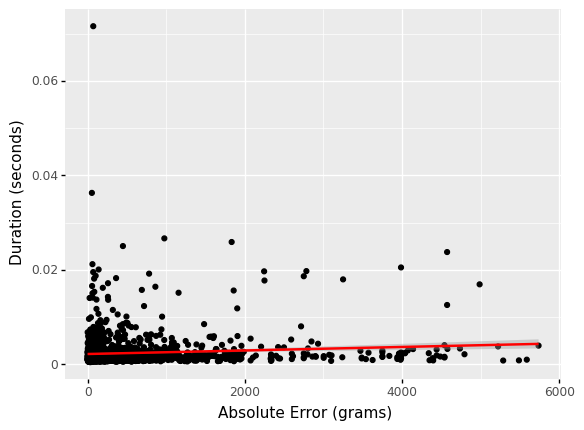

In [44]:
print('Absolute Error - Duration - Relationship:')
cor, p = pearsonr(df['absolute_error'], df['duration'])
print(f'{cor:.2f}, {p * 100:.2f}%')

df['duration'] = df['duration'].apply(lambda duration: duration / 1000)
fig, plot = (ggplot(df, aes(x='absolute_error', y='duration')) \
    + geom_point() \
    + geom_smooth(color='red') \
    + labs(x='Absolute Error (grams)', y='Duration (seconds)')\
    ).draw(show=False, return_ggplot=True)

fig.savefig('survey-duration-correlation.png', bbox_inches = 'tight')
plot